# Image Classification Model #

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
path_to_src = os.path.join('../', 'src')
sys.path.insert(0, path_to_src)
from functions import *
%matplotlib inline

Using TensorFlow backend.


The following function will outut the graphical line graph of a model's performance on Recall, Precision, and Loss.

In [73]:
def visualize_training_results(history, iteration):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['recall_{}'.format(iteration)])
    ax1.plot(history.history['val_recall_{}'.format(iteration)])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(history.history['precision_{}'.format(iteration)])
    ax3.plot(history.history['val_precision_{}'.format(iteration)])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    

### Splitting the data ###

In this dataset we have a training and testing directories. We will be using the testing directory as our holdout validation data (data we will use to validate out model), and the training directory as our main train/test data.

In [74]:
data_dir_train = '../data/train/'
data_dir_test = '../data/test/'
categories = ['NORMAL', 'PNEUMONIA']

Let's output one of the images of our training data.

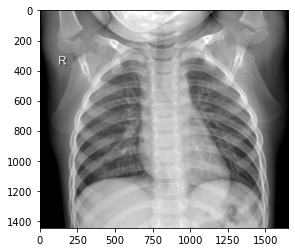

In [76]:
for category in categories:
    path_train = os.path.join(data_dir_train,category)
    for img in os.listdir(path_train):
        img_array_train = cv2.imread(os.path.join(path_train,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_train, cmap="gray")
        plt.show()
        break
    break

Now let's output one of our images from our testing (holdout data).

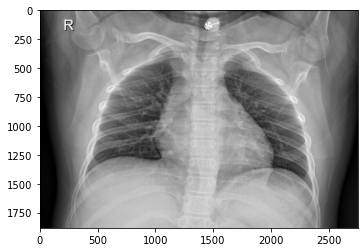

In [77]:
for category in categories:
    path_test = os.path.join(data_dir_test,category)
    for img in os.listdir(path_test):
        img_array_test = cv2.imread(os.path.join(path_test,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_test, cmap="gray")
        plt.show()
        break
    break

Let's see the img array shape

In [83]:
print(img_array_train.shape)
print(img_array_test.shape)

(1446, 1654)
(1882, 2752)


We don't want to bog down our model, therefore let's resize our image to a smaller resolution to provide efficiency and streamline the inputs into the model.

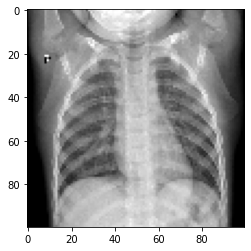

In [84]:
img_size = 100
train_array = cv2.resize(img_array_train,(img_size, img_size))
plt.imshow(train_array, cmap = 'gray')
plt.show()

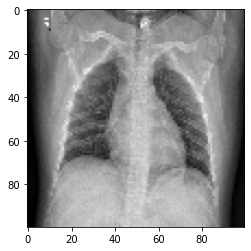

In [85]:
test_array = cv2.resize(img_array_test, (img_size, img_size))
plt.imshow(test_array, cmap = 'gray')
plt.show()

### Creating our datasets ###

In [86]:
train_data = []
test_data = []

Defining our functions to create our datasets for training and testing.

In [87]:
def create_training_data():
    for category in categories:
        path_train = os.path.join(data_dir_train,category)
        class_num = categories.index(category)
        for img in os.listdir(path_train):
            try:
                img_array_train = cv2.imread(os.path.join(path_train,img), cv2.IMREAD_GRAYSCALE)
                train_array = cv2.resize(img_array_train,(img_size, img_size))
                train_data.append([train_array, class_num])
            except Exception as e:
                pass
            
            
def create_testing_data():
    for category in categories:
        path_test = os.path.join(data_dir_test,category)
        class_num = categories.index(category)
        for img in os.listdir(path_test):
            try:
                img_array_test = cv2.imread(os.path.join(path_test,img), cv2.IMREAD_GRAYSCALE)
                test_array = cv2.resize(img_array_test,(img_size, img_size))
                test_data.append([test_array, class_num])
            except Exception as e:
                pass

In [88]:
create_training_data()
create_testing_data()

Let's check the size length of the training and test data.

In [89]:
print('Training data count: {}'.format(len(train_data)))
print('Testing data count: {}'.format(len(test_data)))

Training data count: 5232
Testing data count: 624


In [90]:
random.shuffle(train_data)

In [91]:
random.shuffle(test_data)

Checking on the outputs of the labels per dataset.

In [92]:
for sample in train_data[:5]:
    print('Train', sample[1])
    
for sample in test_data[:5]:
    print('Testing', sample[1])

Train 1
Train 1
Train 0
Train 1
Train 0
Testing 1
Testing 0
Testing 1
Testing 1
Testing 0


Now it's time to split our data into its features and labels for both our training dataset and the testing (holdout) dataset.

In [98]:
X = []
y = []

In [99]:
Xtest = []
ytest = []

In [100]:
for features, label in train_data:
    X.append(features)
    y.append(label)

In [101]:
for features, label in test_data:
    Xtest.append(features)
    ytest.append(label)

Let's verify the that we don't have duplicates in our images. The following for loop should tell us which images are duplicates. If we have a significant amount of duplicates (5% or more) we will remove them from our dataset to prevent it from messing with our model's performance.

In [110]:
len(X)

5232

In [103]:
for idx, img in enumerate(X):
    for idx2, img2 in enumerate(X[idx+1:len(X)]):
        if np.array_equal(img, img2):
            print('duplicate found in: {}, {}'.format(idx, (idx + idx2 + 1)))

duplicate found in: 67, 76
duplicate found in: 67, 2243
duplicate found in: 76, 2243
duplicate found in: 216, 4772
duplicate found in: 259, 1612
duplicate found in: 268, 358
duplicate found in: 279, 1141
duplicate found in: 504, 1505
duplicate found in: 511, 4585
duplicate found in: 624, 1761
duplicate found in: 630, 2251
duplicate found in: 690, 2999
duplicate found in: 879, 2925
duplicate found in: 903, 2879
duplicate found in: 1056, 4025
duplicate found in: 1102, 3900
duplicate found in: 1632, 3299
duplicate found in: 1773, 1903
duplicate found in: 1773, 3597
duplicate found in: 1903, 3597
duplicate found in: 2058, 3124
duplicate found in: 2148, 2624
duplicate found in: 2160, 4375
duplicate found in: 2716, 4860
duplicate found in: 3163, 5181
duplicate found in: 3324, 3642
duplicate found in: 4298, 4913
duplicate found in: 4299, 4969


It appears that we have 28 duplicate images which is less than 5% of the dataset which is comprised of 5232 images.

Let's see if the images visually look the same.

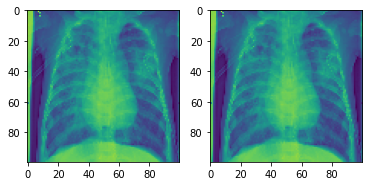

In [111]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(X[67])
ax2.imshow(X[76])

These images visually look exactly the same. Since the it is a very tiny percentage of the overall dataset where we have duplicates we are not going to remove them.

### Reshaping our image arrays ###

In order for our models to take the data of all of our images we will stramline the size to 100,100,1.

In [112]:
X = np.array(X).reshape(-1, img_size, img_size, 1)

In [113]:
X = X/255.0

In [114]:
X.shape

(5232, 100, 100, 1)

Let's do the same to our testing dataset.

In [115]:
Xtest = np.array(Xtest).reshape(-1, img_size, img_size, 1)

In [116]:
Xtest = Xtest/255.0

In [117]:
Xtest.shape

(624, 100, 100, 1)

### Splitting our training dataset into our train and testing set ###

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=40)

In [119]:
X_train.shape

(3924, 100, 100, 1)

Let's encode our labels for the training and holdout dataset.

In [120]:
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [32]:
y_train = np.array(y_train)
y_test = np.array(y_test)

Encoding our testing/holdout dataset.

In [121]:
ytest = keras.utils.to_categorical(ytest, num_classes)

In [122]:
ytest = np.array(ytest)

Let's see the shape of our split data and the holdout dataset before we fit and evaluate our models.

In [123]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3924, 100, 100, 1)
(3924, 2)
(1308, 100, 100, 1)
(1308, 2)


In [125]:
print(Xtest.shape)
print(ytest.shape)

(624, 100, 100, 1)
(624, 2)


In [126]:
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (3924, 100, 100, 1)
3924 train samples
1308 test samples


# Baseline Model #

It's time to see how our first model performs. We will not add too many layers just the basics and see how it performs on our Recall.

In [127]:
base_line = Sequential()
base_line.add(Conv2D(32, kernel_size= 5, activation='relu', padding='same', input_shape=(100, 100, 1)))
base_line.add(MaxPooling2D(2,2))
base_line.add(Flatten())
base_line.add(Dense(16, activation='relu'))
base_line.add(Dense(2, activation='sigmoid'))

In [128]:
base_line.compile(loss="binary_crossentropy", optimizer="adam", metrics = [Precision(), Recall()])


In [129]:
base_line.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 32)      832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1280016   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 1,280,882
Trainable params: 1,280,882
Non-trainable params: 0
_________________________________________________________________


In [53]:
start = time.time()
history_baseline = base_line.fit(X_train,
                      y_train,
                      batch_size = 32,
                      epochs = 5,
                                validation_split = .25)
end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 2943 samples, validate on 981 samples
Epoch 1/5
2943/2943 [==============================] - 20s 7ms/step - loss: 0.4451 - precision_1: 0.7698 - recall_1: 0.7523 - val_loss: 0.2922 - val_precision_1: 0.9101 - val_recall_1: 0.9083
Epoch 2/5
2943/2943 [==============================] - 18s 6ms/step - loss: 0.2827 - precision_1: 0.9180 - recall_1: 0.9164 - val_loss: 0.2621 - val_precision_1: 0.9060 - val_recall_1: 0.9042
Epoch 3/5
2943/2943 [==============================] - 18s 6ms/step - loss: 0.2404 - precision_1: 0.9435 - recall_1: 0.9426 - val_loss: 0.2146 - val_precision_1: 0.9489 - val_recall_1: 0.9470
Epoch 4/5
2943/2943 [==============================] - 17s 6ms/step - loss: 0.2320 - precision_1: 0.9493 - recall_1: 0.9477 - val_loss: 0.2239 - val_precision_1: 0.9673 - val_recall_1: 0.9664
Epoch 5/5
2943/2943 [==============================] - 18s 6ms/step - loss: 0.2047 - precision_1: 0.9564 - recall_1: 0.9545 - val_loss: 0.2067 - val_precision_1: 0.9500 - val_recall_1: 

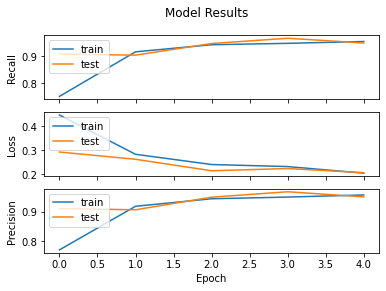

In [54]:
visualize_training_results(history_baseline,1)

In [ ]:
results_train = base_line.evaluate(X_train, y_train)
results_test = base_line.evaluate(X_test, y_test)

In [ ]:
print("%s: %.2f%%" % (base_line.metrics_names[2], results_train[1]*100))
print("%s: %.2f%%" % (base_line.metrics_names[2], results_test[1]*100))

# Model 2 #

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_2.add(MaxPooling2D(4,4))
model_2.add(Flatten())
model_2.add(Dense(64, activation = 'relu'))
model_2.add(Dense(2, activation = 'sigmoid'))

In [ ]:
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [ ]:
model_2.summary()

In [ ]:
start = time.time()
history_model_2 = model_2.fit(X_train,
                              y_train,
                              batch_size = 32,
                              epochs = 5,
                              validation_data = (X_test,y_test))
end = time.time()
print('Minutes: {}'.format((end-start)/60))

In [ ]:
results_train = model_2.evaluate(X_train, y_train)
results_test = model_2.evaluate(X_test, y_test)

In [ ]:
print("Train %s: %.2f%%" % (model_2.metrics_names[2], results_train[1]*100))
print("Test %s: %.2f%%" % (model_2.metrics_names[2], results_test[1]*100))

In [ ]:
visualize_training_results(history_model_2, 2)

# Model 3 #

In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(128, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_3.add(Dense(64, activation = 'tanh'))
model_3.add(MaxPooling2D(4,4))
model_3.add(Flatten())
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dense(16, activation = 'sigmoid'))
model_3.add(Dense(2, activation = 'sigmoid'))

In [ ]:
model_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [ ]:
model_3.summary()

In [ ]:
start = time.time()
history_model_3 = model_3.fit(X_train,
                              y_train,
                              batch_size= 32,
                              epochs = 10,
                             validation_data = (X_test, y_test))

end = time.time()
print('Minutes: {}'.format((end-start)/60))

In [ ]:
visualize_training_results(history_model_3, 3)

In [ ]:
results_train = model_3.evaluate(X_train, y_train)
results_test = model_3.evaluate(X_test, y_test)

In [ ]:
print("Train %s: %.2f%%" % (model_3.metrics_names[2], results_train[1]*100))
print("Test %s: %.2f%%" % (model_3.metrics_names[2], results_test[1]*100))

In [ ]:
model_yaml = model_3.to_yaml()
with open("model_3.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_3.save_weights("model_3.h5")
print("Saved model to disk")

In [ ]:
yaml_file = open('model_3.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_3.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [ ]:
score = loaded_model.evaluate(Xtest, ytest)
print('------------------------------------')
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))

# Model 4 #

In [ ]:
model_4 = Sequential()
model_4.add(Conv2D(128, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_4.add(Dense(64, activation = 'tanh'))
model_4.add(MaxPooling2D(4,4))
model_4.add(Flatten())
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dense(16, activation = 'sigmoid'))
model_4.add(Dense(8, activation = 'tanh'))
model_4.add(Dense(2, activation = 'sigmoid'))

In [ ]:
model_4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [ ]:
model_4.summary()

In [ ]:
start = time.time()
history_model_4 = model_4.fit(X_train,
                              y_train,
                              batch_size = 64,
                              epochs = 15,
                              validation_data = (X_test, y_test))
end = time.time()
print('Minutes: {}'.format((end-start)/60))

In [ ]:
visualize_training_results(history_model_4, 4)

In [ ]:
results_train = model_4.evaluate(X_train, y_train)
results_test = model_4.evaluate(X_test, y_test)

In [ ]:
print("Train %s: %.2f%%" % (model_4.metrics_names[2], results_train[2]*100))
print("Test %s: %.2f%%" % (model_4.metrics_names[2], results_test[2]*100))

In [ ]:
from keras.models import load_model

In [ ]:
model_yaml = model_4.to_yaml()
with open("model_4.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_4.save_weights("model_4.h5")
print("Saved model to disk")

In [ ]:
yaml_file = open('model_4.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_4.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [ ]:
score = loaded_model.evaluate(Xtest, ytest)
print('------------------------------------')
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))

# Model Explanation #

In [ ]:
# from lime import lime_image

In [ ]:
# explainer = lime_image.LimeImageExplainer()

In [ ]:
# explanation = explainer.explain_instance(X_train[0], 
                                         model_3.predict, hide_color=0, num_samples=1000)